In [104]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
import tensorflow as tf

from datetime import datetime
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyDOE.doe_lhs import lhs
from scipy.interpolate import griddata
from scipy.optimize import minimize, show_options


pi = tf.constant(np.pi, dtype=tf.float32)

# Continuous Time Model of solution of Burguers' Equation $u(t, x)$

In [2]:
data = scipy.io.loadmat(os.path.join('.', 'Data', 'burgers_shock.mat'))

In [3]:
N_u = 100
N_f = 10000

In [4]:
t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x, t)

# (x, t)
X_star = np.c_[X.flatten()[:, None], T.flatten()[:, None]]
u_star = Exact.flatten()[:, None]

# Domain bounds (x, t)
lb = X_star.min(0)
ub = X_star.max(0)  

In [5]:
xx1 = np.c_[X[0:1,:].T, T[0:1,:].T]
uu1 = Exact[0:1,:].T
xx2 = np.c_[X[:,0:1], T[:,0:1]]
uu2 = Exact[:,0:1]
xx3 = np.c_[X[:,-1:], T[:,-1:]]
uu3 = Exact[:,-1:]

X_u_train = np.r_[xx1, xx2, xx3]
X_f_train_ = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.r_[X_f_train_, X_u_train]

u_train = np.r_[uu1, uu2, uu3]

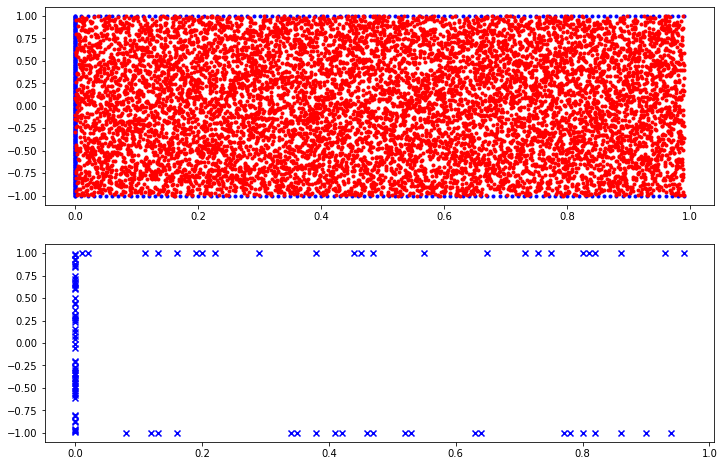

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.scatter(X_u_train[:, 1], X_u_train[:, 0], c='blue', marker='.')
ax1.scatter(X_f_train_[:, 1], X_f_train_[:, 0], c='red', marker='.')

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

ax2.scatter(X_u_train[:, 1], X_u_train[:, 0], c='blue', marker='x')

plt.show()

In [80]:
class NeuralNet(tf.keras.Model):
    def __init__(self, layers, ub, lb):
        super(NeuralNet, self).__init__()
        self.ub, self.lb = ub, lb
        self.input_layer = tf.keras.layers.Dense(units=layers[0], 
                                                 activation=tf.nn.tanh, 
                                                 kernel_initializer=tf.keras.initializers.HeNormal(), 
                                                 input_shape=(2,))
        self.hidden_layers = [tf.keras.layers.Dense(units=units, 
                                                    activation=tf.nn.tanh, 
                                                    kernel_initializer=tf.keras.initializers.HeNormal()) for units in layers[1:]]
        self.output_layer = tf.keras.layers.Dense(units=1, 
                                                  kernel_initializer=tf.keras.initializers.HeNormal())

    def call(self, x):
        x = 2. * (x - self.lb) / (self.ub - self.lb) - 1.
        x = self.input_layer(x)
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
        return self.output_layer(x)


layers = [20, 20, 20, 20, 20, 20, 20, 20]
neural_net = NeuralNet(layers, ub, lb)
u = neural_net(X_u_train)

In [81]:
neural_net.summary()

Model: "neural_net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             multiple                  60        
                                                                 
 dense_10 (Dense)            multiple                  420       
                                                                 
 dense_11 (Dense)            multiple                  420       
                                                                 
 dense_12 (Dense)            multiple                  420       
                                                                 
 dense_13 (Dense)            multiple                  420       
                                                                 
 dense_14 (Dense)            multiple                  420       
                                                                 
 dense_15 (Dense)            multiple                 

In [116]:
def weights_to_vector(model):
    params = np.array([])
    for layer in model.layers:
        weights, bias = layer.get_weights()
        params = np.concatenate([params, weights.flatten(), bias], axis=None)
    return params

def grads_to_vector(gradients):
    grads_vector = np.array([])
    for grad in gradients:
        grads_vector = np.concatenate([grads_vector, grad.numpy().flatten()], axis=None)
    return grads_vector

def vector_to_weights(params, model):
    last_layers_size = 0
    for layer in model.layers:
        w, b = layer.get_weights()
        layer_weights = [
            params[last_layers_size:last_layers_size + np.multiply(*w.shape)].reshape(w.shape), 
            params[last_layers_size + np.multiply(*w.shape):last_layers_size + np.multiply(*w.shape) + b.shape[0]]
        ]
        last_layers_size += np.multiply(*w.shape) + b.shape[0]
        layer.set_weights(layer_weights)

@tf.function
def net_u(x, t):
    u = neural_net(tf.concat([x, t], 1))
    return u
    
@tf.function
def net_f(x, t):
    u = net_u(x, t)
    u_t = tf.gradients(u, t)[0]
    u_x = tf.gradients(u, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    f = u_t + u * u_x - (0.01 / pi) * u_xx
    return f
    
@tf.function
def loss_function(u_hat, f_hat, u):
    mse_u = tf.reduce_mean(tf.square(u - u_hat))
    mse_f = tf.reduce_mean(tf.square(f_hat))
    return mse_u + mse_f

@tf.function
def loss_and_grad_function(model, x_u, t_u, x_f, t_f, u):
    with tf.GradientTape() as tape:
        u_hat = net_u(x_u, t_u)
        f_hat = net_f(x_f, t_f)        
        loss = loss_function(u_hat, f_hat, u)
    grads = tape.gradient(loss, model.trainable_variables)
    return loss, grads

def cost_function(params, model, x_u, t_u, x_f, t_f, u):
    vector_to_weights(params, model)
    loss, grads = loss_and_grad_function(model, x_u, t_u, x_f, t_f, u)
    return loss, grads_to_vector(grads)

def callback(params):
    u_hat = net_u(x_u, t_u)
    f_hat = net_f(x_f, t_f)
    loss = loss_function(u_hat, f_hat, u)
    print(f'Loss: {loss}')

    
x_u = tf.convert_to_tensor(X_u_train[:, [0]], dtype=tf.float32)
t_u = tf.convert_to_tensor(X_u_train[:, [1]], dtype=tf.float32)

x_f = tf.convert_to_tensor(X_f_train[:, [0]], dtype=tf.float32)
t_f = tf.convert_to_tensor(X_f_train[:, [1]], dtype=tf.float32)

u = tf.convert_to_tensor(u_train, dtype=tf.float32)

## Using ```scipy.optimize``` L-BFGS-B optimizer

In [117]:
params0 = weights_to_vector(neural_net)

In [121]:
show_options('minimize', method='L-BFGS-B')

Minimize a scalar function of one or more variables using the L-BFGS-B
algorithm.

Options
-------
disp : None or int
    If `disp is None` (the default), then the supplied version of `iprint`
    is used. If `disp is not None`, then it overrides the supplied version
    of `iprint` with the behaviour you outlined.
maxcor : int
    The maximum number of variable metric corrections used to
    define the limited memory matrix. (The limited memory BFGS
    method does not store the full hessian but uses this many terms
    in an approximation to it.)
ftol : float
    The iteration stops when ``(f^k -
    f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol``.
gtol : float
    The iteration will stop when ``max{|proj g_i | i = 1, ..., n}
    <= gtol`` where ``pg_i`` is the i-th component of the
    projected gradient.
eps : float or ndarray
    If `jac is None` the absolute step size used for numerical
    approximation of the jacobian via forward differences.
maxfun : int
    Maximum number of functi

In [122]:
options = {
    'maxiter': 50000,
    'maxfun': 50000,
    'maxcor': 50,
    'maxls': 50,
    'ftol': 1. * np.finfo(float).eps
}

results = minimize(cost_function, params0, jac=True, method='L-BFGS-B', 
                   args=(neural_net, x_u, t_u, x_f, t_f, u), options=options, callback=callback)

Loss: 5.751743793487549
Loss: 1.768132209777832
Loss: 1.183180332183838
Loss: 0.8810449838638306
Loss: 0.5552368760108948
Loss: 0.4151504933834076
Loss: 0.36215391755104065
Loss: 0.34569185972213745
Loss: 0.314609169960022
Loss: 0.30019059777259827
Loss: 0.26346004009246826
Loss: 0.2615523934364319
Loss: 0.23889708518981934
Loss: 0.23362283408641815
Loss: 0.22115105390548706
Loss: 0.2062385529279709
Loss: 0.1856437772512436
Loss: 0.18472185730934143
Loss: 0.17545172572135925
Loss: 0.1733626127243042
Loss: 0.17098551988601685
Loss: 0.1685677468776703
Loss: 0.16326776146888733
Loss: 0.1581076979637146
Loss: 0.15566101670265198
Loss: 0.15345245599746704
Loss: 0.15236796438694
Loss: 0.15062053501605988
Loss: 0.14752262830734253
Loss: 0.14284299314022064
Loss: 0.13891685009002686
Loss: 0.13649509847164154
Loss: 0.13413164019584656
Loss: 0.13118025660514832
Loss: 0.12772686779499054
Loss: 0.12449964135885239
Loss: 0.1216321736574173
Loss: 0.11837776005268097
Loss: 0.11516264826059341
Loss: 0

## Paper code result

**Loss**: 2.8863915e-06  
**Loss**: 2.8863915e-06  
**Loss**: 2.8863915e-06  
**Loss**: 2.8863915e-06  
**Loss**: 2.8863915e-06  

Training time: 205.8400  

**Error u**: 2.734814e-03 (0.002734814)

Error u: 0.001402629398282907


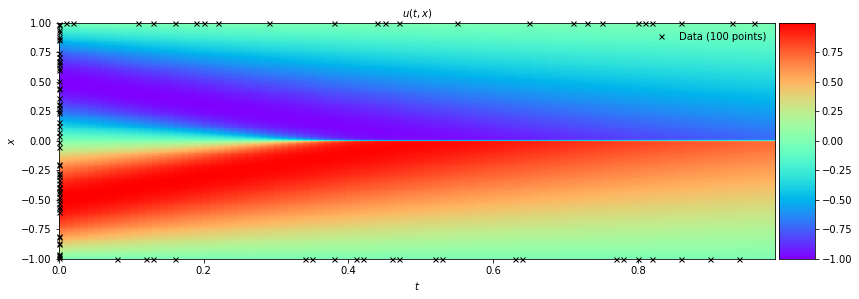

In [123]:
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

x_star = tf.convert_to_tensor(X_star[:, [0]], dtype=tf.float32)
t_star = tf.convert_to_tensor(X_star[:, [1]], dtype=tf.float32)

u_hat = net_u(x_star, t_star).numpy()
f_hat = net_f(x_star, t_star).numpy()

error_u = np.linalg.norm(u_star-u_hat, 2) / np.linalg.norm(u_star, 2)
print(f'Error u: {error_u}')  

U_pred = griddata(X_star, u_hat.flatten(), (X, T), method='cubic')

fig, ax = newfig(15, 12)
ax.axis('off')

################## u(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx', label=f'Data ({u_train.shape[0]} points)', markersize=5, clip_on=False)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc='upper right')
ax.set_title('$u(t,x)$', fontsize=10)

plt.show()

In [124]:
from IPython.display import display, HTML

fig, ax = plt.subplots(figsize=(7, 6))

def animation_func(t):
    error_u = np.linalg.norm(Exact[t, :] - U_pred[t, :], 2) / np.linalg.norm(Exact[t, :], 2)
    ax.clear()
    ax.plot(x, U_pred[t, :], label='Prediction', c='red')
    ax.plot(x, Exact[t, :], label='Exact', c='blue')
    ax.set_xlim((-1., 1.))
    ax.set_ylim((-1.05, 1.05))
    ax.set_title('$t = 0.{}$, $error = {}$'.format(t, np.round(error_u, 4)))
    ax.legend(frameon=False, loc='upper right')
    ax.grid()

anim = FuncAnimation(ax.figure, animation_func, frames=np.arange(1, 100), interval=75)
display(HTML(anim.to_jshtml(default_mode='once')))
plt.close()